In [1]:
import nifty8.re as jft
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib widget


import jax
from jax import random

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


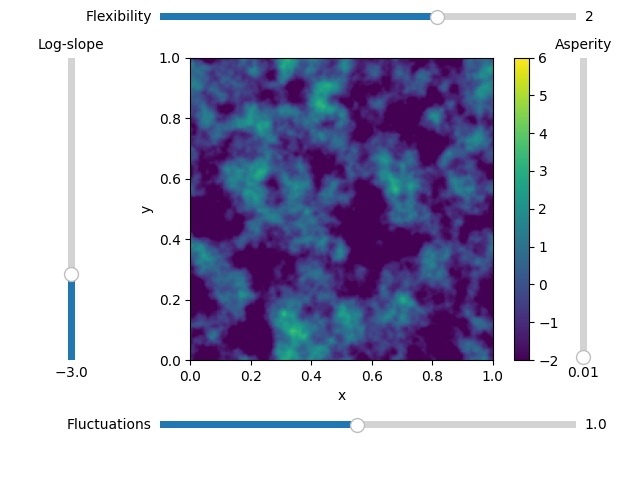

In [2]:
jax.config.update("jax_enable_x64", True)

seed = 43
key = random.PRNGKey(seed)


dims = (128, 128)
padding_factor = 1.5 #decrease padding factor and dimensionality in case widget lags too much
padded_dims = tuple(int(padding_factor * d) for d in dims) 
extent = [0,1,0,1] #xmin, xmax, ymin, ymax
dx, dy= (extent[1] - extent[0])/(dims[0] - 1), (extent[3] - extent[2])/(dims[1] - 1)

cf_zm = {"offset_mean": 0., "offset_std": (1., .5)}


def cfm_space(fluc, slope, flex, asp):
    cfm = jft.CorrelatedFieldMaker("cf_")
    cfm.set_amplitude_total_offset(**cf_zm)
    cfm.add_fluctuations(
        padded_dims,
        distances = (dx, dy),
        fluctuations = (fluc, 0.5), #variances are hyperparameters that can be adjusted at will
        loglogavgslope = (slope, 1.5),
        flexibility = (flex, .2),
        asperity = (asp, .01),
        harmonic_domain_type = "Fourier",
        prefix="ax_spatial",
        non_parametric_kind="power"
    )
    correlated_field = cfm.finalize()
    cfm_sample = correlated_field(jft.random_like(key, correlated_field.domain))
    return cfm_sample

# Create the figure in terms of the function (i.e. cfm_space) that we will manipulate
init_fluc, init_slope, init_flex, init_asp = 1, -3, 2, .01 #parameters that the widget is initialized with
fig, ax = plt.subplots()
min_val, max_val = -2, 6 #determines max and min value of imshow and therefore of the colorbar
im = ax.imshow(cfm_space(init_fluc, init_slope, init_flex, init_asp), extent = extent, vmin = min_val, vmax = max_val)
cbar = fig.colorbar(im)
ax.set_xlabel('x')
ax.set_ylabel('y')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make horizontal and vertical sliders to control the fluctuation parameter.
# [xmin,ymin,dx,dy]
axfluc = fig.add_axes([0.25, 0.1, 0.65, 0.03])
fluc_slider = Slider(
    ax=axfluc,
    label='Fluctuations',
    valmin=0.1,
    valmax=2.,
    valinit=init_fluc
)
axslope = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
slope_slider = Slider(
    ax=axslope,
    label='Log-slope',
    valmin=-4.,
    valmax=-.5,
    valinit=init_slope,
    orientation="vertical"
)
axflex = fig.add_axes([0.25, 0.95, 0.65, 0.03])
flex_slider = Slider(
    ax=axflex,
    label='Flexibility',
    valmin=1e-10,
    valmax=3.,
    valinit=init_flex,
)
axasp = fig.add_axes([0.9, 0.25, 0.0225, 0.63])
asp_slider = Slider(
    ax=axasp,
    label='Asperity',
    valmin=1e-10,
    valmax=1.,
    valinit=init_asp,
    orientation="vertical"
)

# The function to be called anytime a slider's value changes
def update(val):
    im.set_data(cfm_space(fluc_slider.val, slope_slider.val, flex_slider.val, asp_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
fluc_slider.on_changed(update)
slope_slider.on_changed(update)
flex_slider.on_changed(update)
asp_slider.on_changed(update)


plt.show()